In [239]:
%load_ext autoreload
%autoreload 2
import helper_functions as hf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
import pandas as pd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Reading Data

In [208]:
# Create a SparkSession
spark = SparkSession.builder.master("local[4]").appName("ClusterShop").getOrCreate()

# set log level to Error
spark.sparkContext.setLogLevel("ERROR")

# Read the Excel file using Pandas
df_pandas = pd.read_excel("Online Retail.xlsx",na_values='')

# Convert the Pandas DataFrame to PySpark DataFrame 
df_spark = spark.createDataFrame(df_pandas)

In [212]:
untouched_df = df_spark

# Analyzing Data

In [242]:
initial_number_of_rows = df_spark.count()
print("Initial number of rows: ", initial_number_of_rows)

Initial number of rows:  541909


In [214]:
spark

In [174]:
df_spark.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [243]:
hf.show_head_as_pandasDf(df_spark)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01,1.69,13047.0,United Kingdom


In [244]:
# percentage of missing values in each column of the DataFrame
from pyspark.sql.functions import col, count, isnan, when
# get columns excluding 'InvoiceDate'
cols = [col for col in df_spark.columns if col != 'InvoiceDate']
# count missing values in each column as a percentage of the total number of values and total number of values in each column
df_spark.select([count(when(~isnan(c), c)).alias(c) for c in cols]).show()
df_spark.select([count(when(isnan(c), c)).alias(c) for c in cols]).show()

+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|   541909|   541909|     540455|  541909|   541909|    406829| 541909|
+---------+---------+-----------+--------+---------+----------+-------+



+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|        0|        0|       1454|       0|        0|    135080|      0|
+---------+---------+-----------+--------+---------+----------+-------+



* Note: 25% of the data not assigned to a certain customer as CustomerID is NaN

In [245]:
import math
# filter out the missing values using map 
df_spark_filtered = df_spark.rdd.map(lambda x: x if not math.isnan(x['CustomerID'])  else None).filter(lambda x: x is not None).toDF()
df_spark_filtered.select([count(when(isnan(c), c)).alias(c) for c in cols]).show()

+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|        0|        0|          0|       0|        0|         0|      0|
+---------+---------+-----------+--------+---------+----------+-------+



In [226]:
print(f"Number of rows after removing missing values: {df_spark_filtered.count()}")

Number of rows after removing missing values: 406829


In [246]:
df_spark_filtered = df_spark_filtered.dropDuplicates()

In [247]:
print(f"Number of rows after removing duplicates: {df_spark_filtered.count()}")

Number of rows after removing duplicates: 401604


* we just remove them as we will cluster customers based on their purchase history

### InvoiceNo
* uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* 6-digit integral number

In [12]:
#count_invoices is unique invoice numbers
count_transactions = df_spark_filtered.select('InvoiceNo').distinct().count()
count_cancelled_transactions= df_spark_filtered.filter(df_spark_filtered['InvoiceNo'].contains('C')).select('InvoiceNo').distinct().count()
cancelled_percentage = count_cancelled_transactions/count_transactions
data = [(count_transactions, count_cancelled_transactions, cancelled_percentage)]
columns = ["count_transactions", "count cancelled transactions", "cancelled_percentage"]
invoice_no_characteristics = spark.createDataFrame(data, columns)
invoice_no_characteristics.toPandas()

23/04/17 17:08:52 WARN TaskSetManager: Stage 17 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/17 17:08:58 WARN TaskSetManager: Stage 23 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,count_transactions,count cancelled transactions,cancelled_percentage
0,22190,3654,0.164669


* almost 16% of orders are cancelled

### check cancelled invoices

In [252]:
df_sorted_CustomerID = df_spark_filtered.sort('CustomerID')
#show first 10 rows
hf.show_head_as_pandasDf(df_sorted_CustomerID)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18,1.04,12346.0,United Kingdom
1,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,12346.0,United Kingdom
2,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07,0.65,12347.0,Iceland
3,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07,1.25,12347.0,Iceland
4,549222,20665,RED RETROSPOT PURSE,6,2011-04-07,2.95,12347.0,Iceland
5,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07,4.25,12347.0,Iceland
6,542237,20966,SANDWICH BATH SPONGE,10,2011-01-26,1.25,12347.0,Iceland
7,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26,0.55,12347.0,Iceland
8,537626,21064,BOOM BOX SPEAKER BOYS,6,2010-12-07,5.95,12347.0,Iceland
9,542237,84969,BOX OF 6 ASSORTED COLOUR TEASPOONS,6,2011-01-26,4.25,12347.0,Iceland


* Look at the first two transactions are the same except for the sign of the quantity
* which mean these two transactions are the same but one is cancelled 

### StockCode
* uniquely assigned to each distinct product
* 5-digit integral number

In [30]:
stock_code_characteristics = spark.createDataFrame([(df_spark_filtered.select('StockCode').count(), df_spark_filtered.select('StockCode').distinct().count())], ['number_of_items', 'number_of_unique_items'])
stock_code_characteristics.toPandas()

23/04/17 23:54:38 WARN TaskSetManager: Stage 195 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/17 23:54:44 WARN TaskSetManager: Stage 201 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,number_of_items,number_of_unique_items
0,401604,3684


In [32]:
#get stock code that only letters and no numbers
from pyspark.sql.functions import regexp_extract
list_special_codes = df_spark_filtered.withColumn("StockCode", regexp_extract(col("StockCode"), "([a-zA-Z]+)", 1))
list_special_codes.select("StockCode").distinct().toPandas()

23/04/17 23:55:40 WARN TaskSetManager: Stage 208 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,StockCode
0,K
1,F
2,POST
3,E
4,T
5,BANK
6,B
7,BL
8,L
9,M


<!-- POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE    -->

* POST            -> POSTAGE                       
* D               -> Discount                      
* C2              -> CARRIAGE                      
* M               -> Manual                        
* BANK CHARGES    -> Bank Charges                  
* PADS            -> PADS TO MATCH ALL CUSHIONS    
* DOT             -> DOTCOM POSTAGE   

In [33]:
#most popular items
df_spark_filtered.groupBy('StockCode').count().orderBy('count', ascending=False).toPandas().head(10)

23/04/17 23:56:05 WARN TaskSetManager: Stage 211 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,StockCode,count
0,85123A,2065
1,22423,1894
2,85099B,1659
3,47566,1409
4,84879,1405
5,20725,1346
6,22720,1224
7,POST,1196
8,22197,1110
9,23203,1108


In [34]:
# least popular items
df_spark_filtered.groupBy('StockCode').count().orderBy('count', ascending=True).toPandas().head(10)

23/04/17 23:56:25 WARN TaskSetManager: Stage 224 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,StockCode,count
0,90197B,1
1,79320,1
2,90199B,1
3,85170A,1
4,90027A,1
5,90129E,1
6,90163B,1
7,90214Z,1
8,82615,1
9,90065B,1


### Description
Product (item) name. Nominal.

In [92]:
description_characteristics = spark.createDataFrame([(df_spark.select('Description').count(), df_spark.select('Description').distinct().count(), df_spark.filter(df_spark.Description.isNull()).count())], ['number_of_items', 'number_of_unique_items', 'number_of_null_values'])
description_characteristics.toPandas()

23/04/17 00:00:23 WARN TaskSetManager: Stage 740 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/17 00:00:29 WARN TaskSetManager: Stage 743 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/17 00:00:35 WARN TaskSetManager: Stage 749 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,number_of_items,number_of_unique_items,number_of_null_values
0,406829,3896,0


In [93]:
# Top products by frequency
df_spark.groupBy('Description').count().orderBy('count', ascending=False).toPandas().head(10)

23/04/17 00:00:41 WARN TaskSetManager: Stage 753 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,Description,count
0,WHITE HANGING HEART T-LIGHT HOLDER,2070
1,REGENCY CAKESTAND 3 TIER,1905
2,JUMBO BAG RED RETROSPOT,1662
3,ASSORTED COLOUR BIRD ORNAMENT,1418
4,PARTY BUNTING,1416
5,LUNCH BAG RED RETROSPOT,1358
6,SET OF 3 CAKE TINS PANTRY DESIGN,1232
7,POSTAGE,1196
8,LUNCH BAG BLACK SKULL.,1126
9,PACK OF 72 RETROSPOT CAKE CASES,1080


In [94]:
# Bottom products by frequency
df_spark.groupBy('Description').count().orderBy('count', ascending=True).toPandas().head(10)

23/04/17 00:00:48 WARN TaskSetManager: Stage 761 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,Description,count
0,POTTING SHED SOW 'N' GROW SET,1
1,PINK BOUDOIR T-LIGHT HOLDER,1
2,BIRTHDAY BANNER TAPE,1
3,JADE CRYSTAL+GLASS BRACELET,1
4,PINK PAINTED KASHMIRI CHAIR,1
5,PINK MARSHMALLOW SCARF KNITTING KIT,1
6,CREAM SWEETHEART SHELF + HOOKS,1
7,BLUE LEAVES AND BEADS PHONE CHARM,1
8,"FLOWER GLASS GARLD NECKL36""TURQUOIS",1
9,NEW BAROQUE B'FLY NECKLACE CRYSTAL,1


### Quantity
The quantities of each product (item) per transaction. Numeric.


In [35]:
df_spark_filtered.select('Quantity').describe().toPandas()

23/04/17 23:58:11 WARN TaskSetManager: Stage 237 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,summary,Quantity
0,count,401604
1,mean,12.183272576966365
2,stddev,250.28303714445425
3,min,-80995
4,max,80995


In [98]:
df_spark.groupBy('Country').sum('Quantity').orderBy('sum(Quantity)', ascending=False).toPandas().head(5)

23/04/17 00:01:25 WARN TaskSetManager: Stage 785 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,Country,sum(Quantity)
0,United Kingdom,4008533
1,Netherlands,200128
2,EIRE,136329
3,Germany,117448
4,France,109848


### CustomerID
*  a 5-digit integral number uniquely assigned to each customer

In [13]:
#get number of unique customers
df_spark_filtered.select('CustomerID').distinct().count()

23/04/17 23:24:00 WARN TaskSetManager: Stage 10 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


4372

In [56]:
# group by CustomerID, InvoiceNo, and count the number of rows
from pyspark.sql.functions import count
temp = df_spark_filtered.groupBy('CustomerID', 'InvoiceNo').agg(count('InvoiceDate').alias('Number of products'))
#sort by ID
temp.sample(False, 0.0005, seed=0).toPandas()


23/04/18 01:27:59 WARN TaskSetManager: Stage 329 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


,CustomerID,InvoiceNo,Number of products
0,12600,563776,9
1,14587,556063,41
2,13483,569631,10
3,15643,C556677,1
4,0,569137,130
5,0,550500,234
6,16255,565472,36
7,0,560407,1
8,14517,574711,4


* Invoices starts whit C are cancelled
* there are customers only buy small quantities of products and other customers buy large quantities of products

### InvoiceDate

In [17]:
#min and max date
print(f"the minimum date is: {df_spark_filtered.select('InvoiceDate').agg({'InvoiceDate': 'min'}).collect()[0][0]}")
print(f"the maximum date is: {df_spark_filtered.select('InvoiceDate').agg({'InvoiceDate': 'max'}).collect()[0][0]}")

23/04/17 23:27:45 WARN TaskSetManager: Stage 32 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/17 23:27:51 WARN TaskSetManager: Stage 35 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


the minimum date is: 2010-12-01 08:26:00


the maximum date is: 2011-12-09 12:50:00


### Country

In [24]:
number_countries=df_spark_filtered.select('Country').distinct().count()
print(f"Number of countries: {number_countries}")

23/04/17 23:40:29 WARN TaskSetManager: Stage 68 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


Number of countries: 37


23/04/17 23:45:22 WARN TaskSetManager: Stage 87 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/17 23:45:27 WARN TaskSetManager: Stage 97 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


Sum of invoice counts: 22190


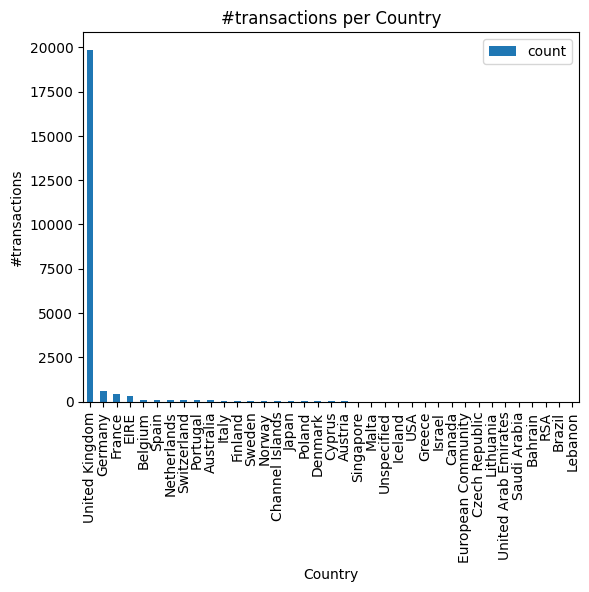

In [26]:
invoice_counts = df_spark_filtered.groupBy(['Country', 'InvoiceNo']).count().groupBy('Country').count().orderBy('count', ascending=False)
#print sum of invoice_counts
print(f"Sum of invoice counts: {invoice_counts.agg({'count': 'sum'}).collect()[0][0]}")
pandas_df = invoice_counts.toPandas()
pandas_df.plot(kind="bar", x="Country", y="count")
plt.title("#transactions per Country")
plt.xlabel("Country")
plt.ylabel("#transactions")
plt.show()

23/04/17 23:46:17 WARN TaskSetManager: Stage 110 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/17 23:46:23 WARN TaskSetManager: Stage 120 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


Sum of cancelled invoice counts: 3654


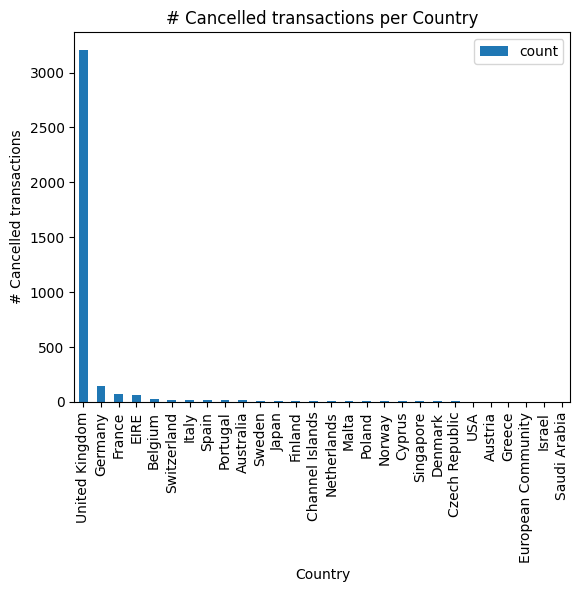

In [27]:
cancelled_invoice_counts = df_spark_filtered.filter(df_spark_filtered['InvoiceNo'].contains('C')).groupBy(['Country', 'InvoiceNo']).count().groupBy('Country').count().orderBy('count', ascending=False)
print(f"Sum of cancelled invoice counts: {cancelled_invoice_counts.agg({'count': 'sum'}).collect()[0][0]}")
pandas_df = cancelled_invoice_counts.toPandas()
pandas_df.plot(kind="bar", x="Country", y="count")
plt.title("# Cancelled transactions per Country")
plt.xlabel("Country")
plt.ylabel("# Cancelled transactions")
plt.show()